# 1. Байесовский и классический подходы

Здесь мы сравним два подхода для расчёта доверительных интервалов: частотный и байесовский.

$\bar{X}$ -- среднее выборки, $s^2$ -- дисперсия выборки.

Частотный(frequentistic) интервал:

$$C_n = \bar{X} \pm t_{n-1} \frac{s}{\sqrt{n}}$$

Байесовский(bayesian) интервал:

$$C_n = \mu_{bayes} \pm t_{n-1} \sigma_{bayes}$$

где,

$$\mu_{bayes} = \frac{1 / \sigma_0^2}{n / s^2 + 1 / \sigma_0^2} \mu_0 + \frac{n / s^2}{n / s^2 + 1 / \sigma_0^2} \bar{X}$$

$$\sigma^2_{bayes} = \frac{s^2 \sigma_0^2}{s^2 + n \sigma_0^2},$$

где, $\mu_0$ и $\sigma_0$ -- априорное знание.

Сравниваться мы будем на 3х распределениях: 
  * стандартном нормальном;
  * экспоненциальном с $\lambda=2$; 
  * бета-распределением с $a=2,~~b=5$.
  
Кроме того, мы будем варьировать $\mu_0$:
  * $\mu_0 = \mu$ -- точное попадание в цель;
  * $\mu_0 = \mu + 0.25 s$ -- наши приоры имеют смещение;
  * $\mu_0 = \mu + 0.5 s$ -- наши приоры имеют __сильное__ смещение;
  
  
$$\sigma_0^2 = \frac{s^2}{12}$$

#### Цитата:

![](prior_sigma.png)

https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2027&context=jmasm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, beta
%matplotlib inline

sns.set(font_scale=2)

In [2]:
from scipy.stats import t
def calc_intervals(distr, bias=0, q=0.95, n=100, true_mean=0):
    X = distr.rvs(size=n)
    X_mean = X.mean()
    X_std = np.std(X, ddof=1)
    t_n_1 = t(df=n - 1).ppf(1 - (1 - q) / 2)
    
    freq_lower_bound, freq_higher_bound = X_mean - t_n_1 * X_std / np.sqrt(n), X_mean + t_n_1 * X_std / np.sqrt(n) 
    
    X_mean_prior = true_mean + ([-1, 1][np.random.randint(2)]) * bias * X_std
    X_std_prior = X_std / np.sqrt(12)
    
    X_mean_bayes = X_mean * (n / X_std**2) / ( n / X_std**2 + 1 / X_std_prior**2 ) + X_mean_prior * (1 / X_std_prior**2) / ( n / X_std**2 + 1 / X_std_prior**2 )
    X_std_bayes = np.sqrt((X_std**2 * X_std_prior**2) / (X_std**2 + n * X_std_prior**2))
    bayes_lower_bound, bayes_higher_bound = X_mean_bayes - t_n_1 * X_std_bayes, X_mean_bayes + t_n_1 * X_std_bayes
    
    return freq_lower_bound, freq_higher_bound, \
           bayes_lower_bound, bayes_higher_bound, \
           (X_mean - true_mean)**2, (X_mean_bayes - true_mean)**2

In [3]:
ns = np.arange(10, 110, 10)

In [4]:
experiments = 1000

In [5]:
def run_stats(ns, distr, experiments=100, true_mean=0, bias=0):
    freq_capture_rates = []
    bayes_capture_rates = []
    mse_bayeses = []
    mse_freqs = []
    for n in ns:
        freq_capture_rate = 0
        bayes_capture_rate = 0
        mse_bayes = 0
        mse_freq = 0
        for _ in range(experiments):
            freq_lower_bound, freq_higher_bound, \
            bayes_lower_bound, bayes_higher_bound, \
            mse_f, mse_b = calc_intervals(distr=distr, bias=bias, n=n, true_mean=true_mean)
            
            freq_capture_rate += (freq_lower_bound < true_mean < freq_higher_bound)
            bayes_capture_rate += (bayes_lower_bound < true_mean < bayes_higher_bound)
            mse_bayes += mse_b # (var_bayes + bias**2)
            mse_freq += mse_f # var_freq
            
        mse_bayeses.append(mse_bayes / experiments)
        mse_freqs.append(mse_freq / experiments)
        freq_capture_rates.append(freq_capture_rate / experiments)
        bayes_capture_rates.append(bayes_capture_rate / experiments)
    return mse_bayeses, mse_freqs, freq_capture_rates, bayes_capture_rates

In [6]:
def draw_comparison(distr, true_mean):
    mse_bayeses, mse_freqs, freq_capture_rates, bayes_capture_rates = run_stats(ns, distr=distr, 
                                                                                true_mean=true_mean, bias=0.0,
                                                                                experiments=experiments)
    freq_capture_rates = np.array(freq_capture_rates)
    bayes_capture_rates = np.array(bayes_capture_rates)
    mse_bayeses = np.array(mse_bayeses)
    mse_freqs = np.array(mse_freqs)

    mse_bayeses_low_bias, _, _, bayes_capture_rates_low_bias = run_stats(ns, distr=distr, 
                                                                         true_mean=true_mean, bias=0.25, 
                                                                         experiments=experiments)
    mse_bayeses_low_bias = np.array(mse_bayeses_low_bias)
    bayes_capture_rates_low_bias = np.array(bayes_capture_rates_low_bias)

    mse_bayeses_high_bias, _, _, bayes_capture_rates_high_bias = run_stats(ns, distr=distr, 
                                                                           true_mean=true_mean, bias=0.5, 
                                                                           experiments=experiments)
    mse_bayeses_high_bias = np.array(mse_bayeses_high_bias)
    bayes_capture_rates_high_bias = np.array(bayes_capture_rates_high_bias)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    # fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0].plot(ns, mse_freqs, label='Frequentist')
    axes[0].plot(ns, mse_bayeses, label='Bayes. No bias.')
    axes[0].plot(ns, mse_bayeses_low_bias, label='Bayes. Low bias.')
    axes[0].plot(ns, mse_bayeses_high_bias, label='Bayes. High bias.')
    axes[1].set_title('MSE')
    axes[0].legend()

    axes[1].plot(ns, freq_capture_rates, label='Frequentist')
    freq_capture_rates_std = np.sqrt(freq_capture_rates * (1 - freq_capture_rates) / experiments)
    axes[1].fill_between(ns, freq_capture_rates - freq_capture_rates_std, freq_capture_rates + freq_capture_rates_std, 
                         alpha=0.3)


    axes[1].plot(ns, bayes_capture_rates, label='Bayes. No bias.')
    bayes_capture_rates_std = np.sqrt(bayes_capture_rates * (1 - bayes_capture_rates) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates - bayes_capture_rates_std, bayes_capture_rates + bayes_capture_rates_std, 
                         alpha=0.3)

    axes[1].plot(ns, bayes_capture_rates_low_bias, label='Bayes. Low bias.')
    bayes_capture_rates_low_bias_std = np.sqrt(bayes_capture_rates_low_bias * (1 - bayes_capture_rates_low_bias) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates_low_bias - bayes_capture_rates_low_bias_std, bayes_capture_rates_low_bias + bayes_capture_rates_low_bias_std, 
                         alpha=0.3)


    axes[1].plot(ns, bayes_capture_rates_high_bias, label='Bayes. High bias.')
    bayes_capture_rates_high_bias_std = np.sqrt(bayes_capture_rates_high_bias * (1 - bayes_capture_rates_high_bias) / experiments)
    axes[1].fill_between(ns, bayes_capture_rates_high_bias - bayes_capture_rates_high_bias_std, bayes_capture_rates_high_bias + bayes_capture_rates_high_bias_std, 
                         alpha=0.3)
    axes[1].axhline(y=0.95, color='r', linestyle='-')
    axes[1].set_title('Capture rate')
    axes[1].legend()

### Стандартное нормальное распределение

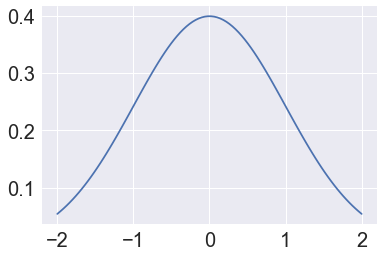

In [7]:
x = np.linspace(-2, 2, 100)
plt.plot(x, (norm().pdf(x)))

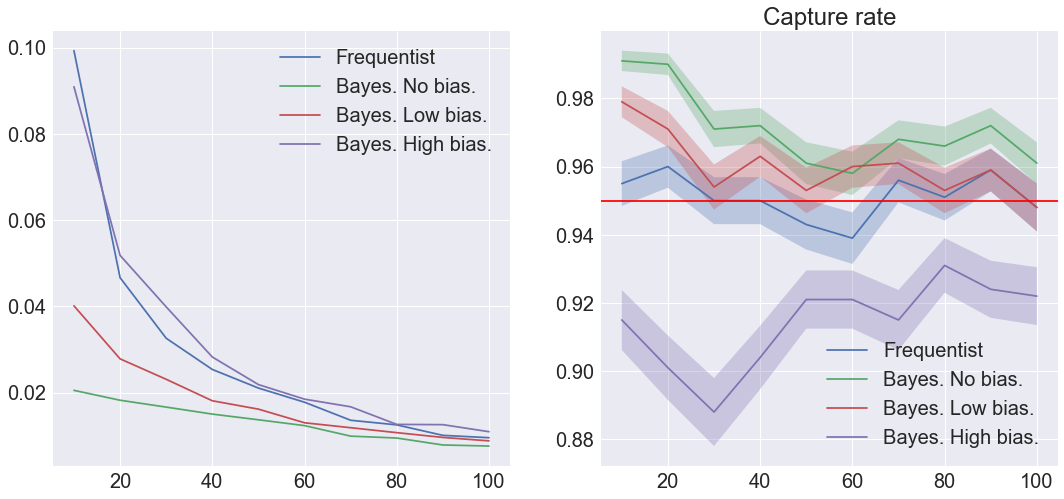

In [8]:
draw_comparison(norm(), 0)

### Экспоненциальное распределение

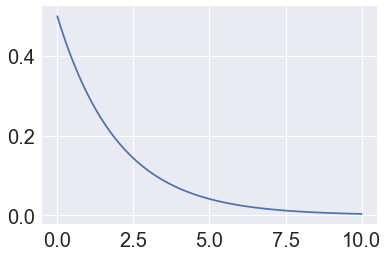

In [9]:
x = np.linspace(0, 10, 100)
plt.plot(x, (expon(scale=2).pdf(x)))

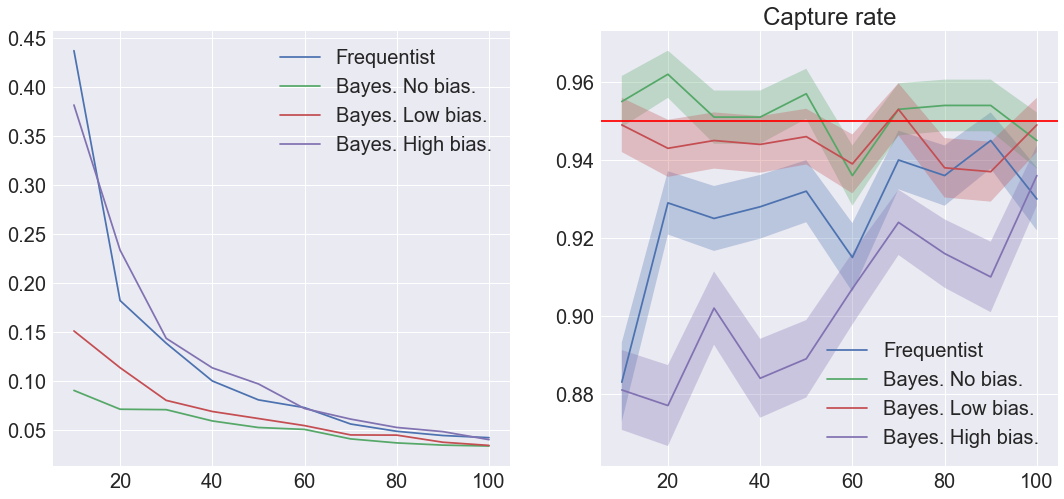

In [10]:
draw_comparison(expon(scale=2), 2)

### Бета распределение

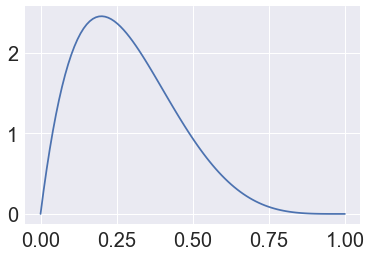

In [11]:
x = np.linspace(0, 1, 100)
plt.plot(x, (beta(a=2, b=5).pdf(x)))

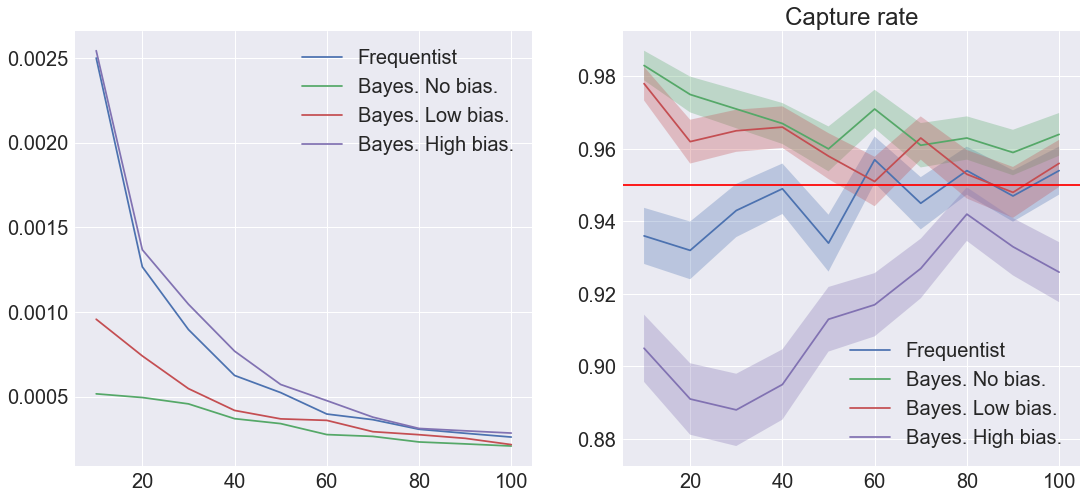

In [12]:
draw_comparison(beta(a=2, b=5), 2 / (2 + 5))

#### Вывод

Байесовские интервалы показывают более хорошее покрытие в сравнении с частотным подходом в случае когда ошибка в априорном значении величины не превышает $\sim 0.25-0.5$ стандартных отклонений.

Поэтому если есть хорошие основания для задания априорных значений величин, то следует предпочесть байесовские интервалы.

# 2. Сравнение  4 типов интервалов

### Оценка доверительного интервала

Будем говорить про оценку среднего, т.е. $\theta = \mu$.

Обозначения:

$$\hat{\theta} = \bar{X}$$

$$\hat{se} = \mathrm{Var}[{X}]$$

$\hat{\theta}^{\alpha}$ -- перцентиль посчитанная по бутстрапной выборке.

##### $1 - 2 \alpha$ центральный интервал:

$$C_n = 2 \hat{\theta} - \hat{\theta}^{(1 - \alpha)}, 2 \hat{\theta} - \hat{\theta}^{(\alpha)}$$


##### $1 - 2 \alpha$ нормальный интервал:

$$C_n = \hat{\theta} + z_{\alpha}v_{boot}, \hat{\theta} + z_{1 - \alpha}v_{boot}$$


##### $1 - 2 \alpha$ перцентильный интервал:

$$C_n = \hat{\theta}^{(\alpha)}, \hat{\theta}^{(1 - \alpha)}$$

##### $1 - 2 \alpha$ bootstrap-t интервал:


Bootstrap-t оценивается по-другому:

$$C_n = \left( \hat{\theta} - \hat{se} \cdot \hat{t}^{(1 - \alpha)}, \hat{\theta} - \hat{se} \cdot \hat{t}^{(\alpha)} \right),$$

где квантили $t$ считаются от следующих оценок по бутстрапным выборкам:

$$t^*(b) = \frac{\hat{\theta}^*(b) - \hat{\theta}}{\hat{se}^*(b)}$$

Мы сравним все 4 метода оценивания интервалов на 4х примерах.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(font_scale=2)

In [14]:
from scipy.stats import cauchy, norm, t, expon, beta

def mean(X):
    return np.mean(X, axis=1)

def mean_t(X, X_original):
    return (np.mean(X, axis=1) - np.mean(X_original)) / np.std(X, axis=1)

def percentile_confidence_interval(X, q=5):
    return np.percentile(X, q=q / 2), np.percentile(X, q=100 - q / 2)

In [15]:
CAPTURE_RATE_NUM = 200

def calculate_intervals(distr):
    X = distr.rvs(size=N)
    boots = np.random.choice(X, (B, N), replace=True)
    mean_boots = mean(boots)
    mean_boots_t = mean_t(boots, X)
    X_std = X.std()
    X_mean = X.mean()
    X_boot_std = np.sqrt(np.sum((mean_boots - X_mean)**2 / (len(mean_boots) - 1)))
    limits = [X_mean + X_boot_std * norm.ppf(0.0001), X_mean + X_boot_std * norm.ppf(.9999)]
    lower_interval_normal, higher_interval_normal = X_mean + X_boot_std * norm.ppf(0.025), X_mean + X_boot_std * norm.ppf(.975)

    lower_interval_percentile, higher_interval_percentile = percentile_confidence_interval(mean_boots)
    
    higher_interval_t, lower_interval_t = percentile_confidence_interval(mean_boots_t)
    lower_interval_t = X.mean() - X_std * lower_interval_t
    higher_interval_t = X.mean() - X_std * higher_interval_t
    
    higher_interval_central, lower_interval_central = percentile_confidence_interval(mean_boots)
    lower_interval_central = X_mean * 2 - lower_interval_central; higher_interval_central = X_mean * 2 - higher_interval_central
    return X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, lower_interval_percentile, higher_interval_percentile, \
           lower_interval_t, higher_interval_t, lower_interval_central, higher_interval_central

def plot_statistics(distr, true_mean=0):
    X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, lower_interval_percentile, higher_interval_percentile, \
           lower_interval_t, higher_interval_t, lower_interval_central, higher_interval_central = calculate_intervals(distr)
    limits = [X_mean + X_boot_std * norm.ppf(0.0001), X_mean + X_boot_std * norm.ppf(.9999)]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
    fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0][0].hist(X, bins=100, density=True);
    axes[0][0].axvline(x=X_mean, linewidth=4, color='r')
    axes[0][0].set_xlim(np.percentile(X, 2), np.percentile(X, 98))
    axes[0][0].set_title('Sample')
    
    axes[0][1].hist(mean_boots, bins=100, density=True);
    axes[0][1].axvline(x=lower_interval_percentile, linewidth=1, 
                    color='r', linestyle='--')
    axes[0][1].axvline(x=higher_interval_percentile, linewidth=1, 
                    color='r', linestyle='--', label='Percentile bootstrap interval')


    axes[0][1].axvline(x=lower_interval_t, linewidth=1, 
                    color='g', linestyle='-', label='t-bootstrap interval')
    axes[0][1].axvline(x=higher_interval_t, linewidth=1, 
                    color='g', linestyle='-')
    
    axes[0][1].axvline(x=lower_interval_central, linewidth=1, 
                    color='b', linestyle='-')
    axes[0][1].axvline(x=higher_interval_central, linewidth=1, 
                    color='b', linestyle='-', label='central interval')
    
    axes[0][1].axvline(x=lower_interval_normal, linewidth=1, 
                    color='k', linestyle='-')
    axes[0][1].axvline(x=higher_interval_normal, linewidth=1, 
                    color='k', linestyle='-', label='normal interval')
    axes[0][1].set_xlim(limits)
    axes[0][1].set_title('Example')
    axes[0][1].legend()
    
    # compute capture rate and mse
    capture_rate_percentile, capture_rate_t, capture_rate_central, capture_rate_normal = 0, 0, 0, 0
    lower_intervals_percentile, lower_intervals_t, lower_intervals_central, lower_intervals_normal = [], [], [], []
    higher_intervals_percentile, higher_intervals_t, higher_intervals_central, higher_intervals_normal = [], [], [], []
    for i in range(CAPTURE_RATE_NUM):
        X, X_mean, X_std, X_boot_std, mean_boots, lower_interval_normal, higher_interval_normal, \
        lower_interval_percentile, higher_interval_percentile, \
        lower_interval_t, higher_interval_t, \
        lower_interval_central, higher_interval_central = calculate_intervals(distr)
        
        lower_intervals_percentile.append(lower_interval_percentile); higher_intervals_percentile.append(higher_interval_percentile)
        lower_intervals_t.append(lower_interval_t); higher_intervals_t.append(higher_interval_t)
        lower_intervals_central.append(lower_interval_central); higher_intervals_central.append(higher_interval_central)
        lower_intervals_normal.append(lower_interval_normal); higher_intervals_normal.append(higher_interval_normal)
        
        capture_rate_percentile += (lower_interval_percentile < true_mean < higher_interval_percentile)
        capture_rate_t += (lower_interval_t < true_mean < higher_interval_t)
        capture_rate_central += (lower_interval_central < true_mean < higher_interval_central)
        capture_rate_normal += (lower_interval_normal < true_mean < higher_interval_normal)
        
    axes[1][0].plot(np.arange(CAPTURE_RATE_NUM), CAPTURE_RATE_NUM * [true_mean])
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_percentile, 
                            higher_intervals_percentile, alpha=0.3, label='percentile interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_t, 
                            higher_intervals_t, alpha=0.3, label='t-bootstrap interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_central, 
                            higher_intervals_central, alpha=0.3, label='central interval')
    axes[1][0].fill_between(np.arange(CAPTURE_RATE_NUM), lower_intervals_normal, 
                            higher_intervals_normal, alpha=0.3, label='normal interval')
    axes[1][0].set_ylim(limits)
    axes[1][0].set_title('Intervals')
    axes[1][0].legend()
    
    capture_rate_percentile = capture_rate_percentile / CAPTURE_RATE_NUM
    capture_rate_t = capture_rate_t / CAPTURE_RATE_NUM
    capture_rate_central = capture_rate_central / CAPTURE_RATE_NUM
    capture_rate_normal = capture_rate_normal / CAPTURE_RATE_NUM
    axes[1][1].bar([0, 1, 2, 3], [capture_rate_percentile, capture_rate_t, capture_rate_central, capture_rate_normal], 
                    yerr=[np.sqrt(capture_rate_percentile * (1 - capture_rate_percentile) / CAPTURE_RATE_NUM), 
                          np.sqrt(capture_rate_t * (1 - capture_rate_t) / CAPTURE_RATE_NUM),
                          np.sqrt(capture_rate_central * (1 - capture_rate_central) / CAPTURE_RATE_NUM),
                          np.sqrt(capture_rate_normal * (1 - capture_rate_normal) / CAPTURE_RATE_NUM)], alpha=0.5,
                   tick_label=['percentile', 't-bootstrap', 'central', 'normal'])
    axes[1][1].plot(np.arange(-1, 5), 6 * [0.95])
    axes[1][1].set_xlim([-0.5, 3.5])
    axes[1][1].set_title('Capture rate')
    plt.show()

In [16]:
N = 50
B = 5000

### Распределение Коши

###### Плотность вероятности:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b2f992bf16e0dc9f79c9d9aa0af80f78657796a9" alt="drawing" width="200"/>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Cauchy_pdf.svg/360px-Cauchy_pdf.svg.png" alt="drawing" width="400"/>

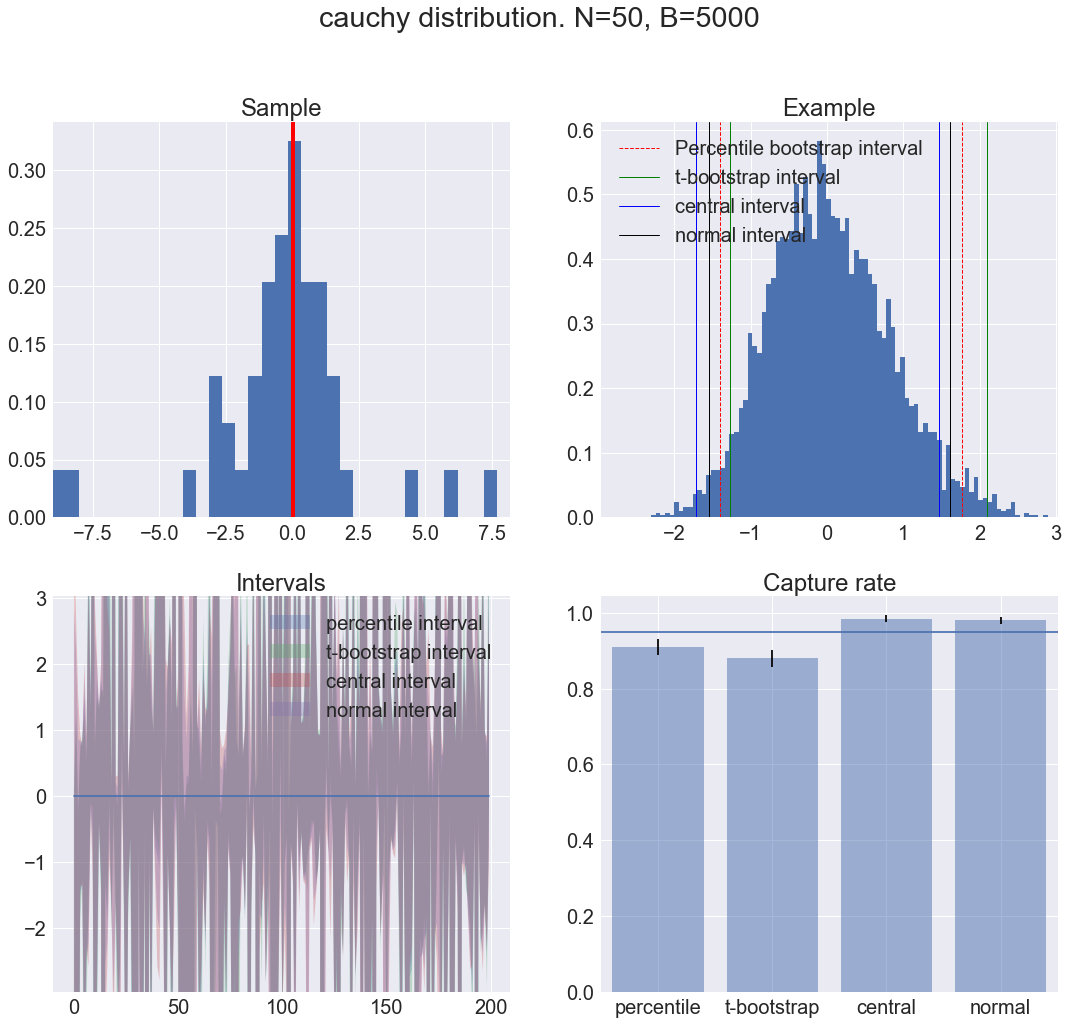

CPU times: user 3.06 s, sys: 1.1 s, total: 4.16 s
Wall time: 2.59 s


In [17]:
%%time
plot_statistics(cauchy(), true_mean=0)

# Нормальное распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/1080px-Normal_Distribution_PDF.svg.png" alt="drawing" width="400"/>

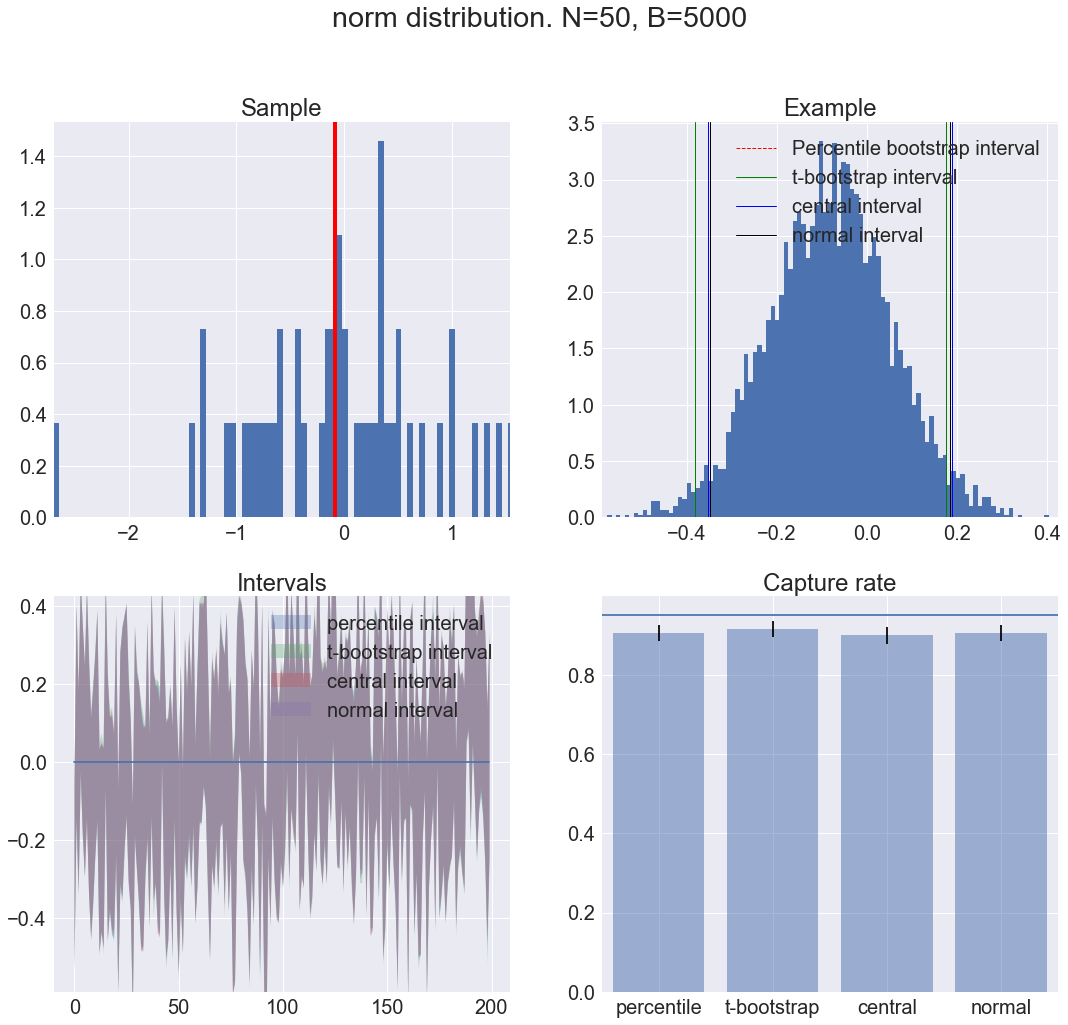

In [18]:
plot_statistics(norm(), true_mean=0)

# Экспоненциальное распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/360px-Exponential_pdf.svg.png" alt="drawing" width="400"/>

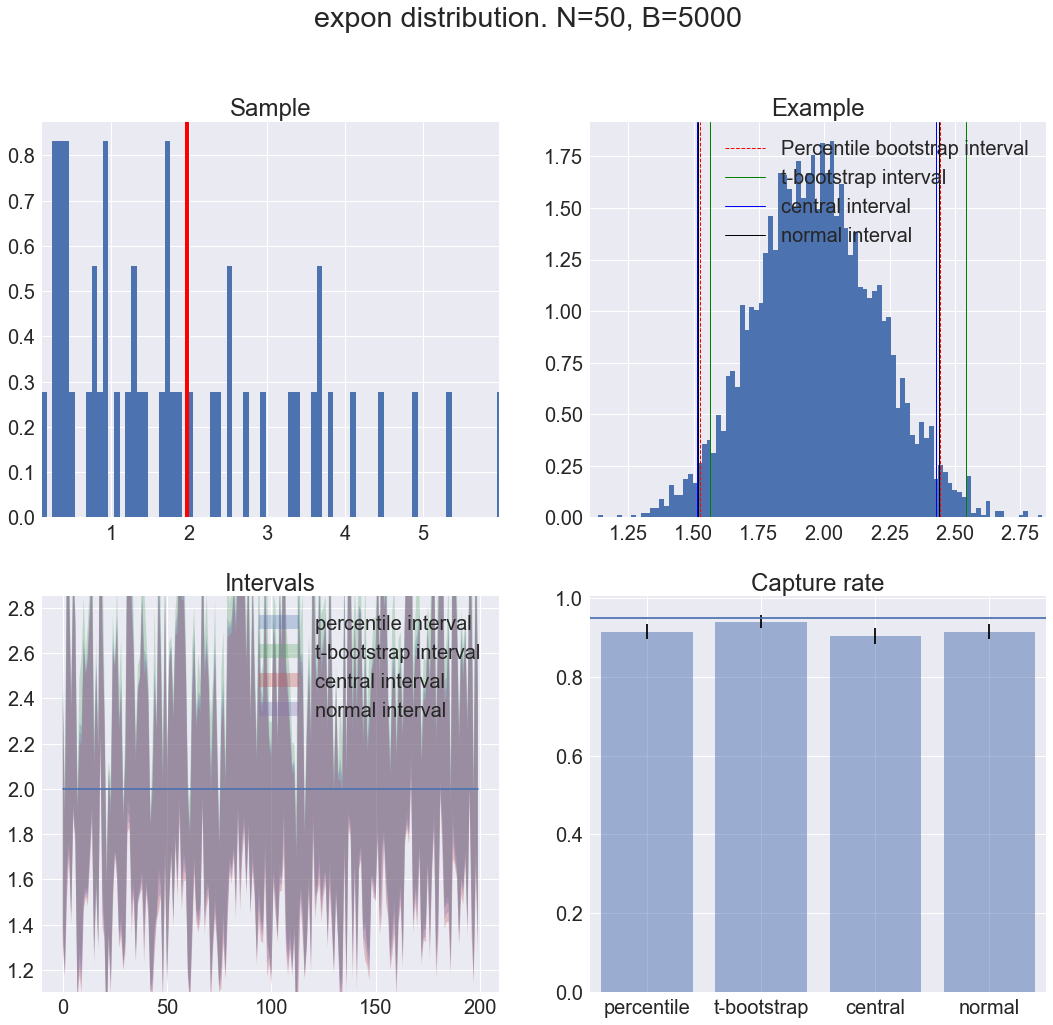

In [19]:
lam = 2
plot_statistics(expon(scale=lam), true_mean=lam)



# Бета распределение

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Beta_distribution_pdf.png/1024px-Beta_distribution_pdf.png" alt="drawing" width="400"/>

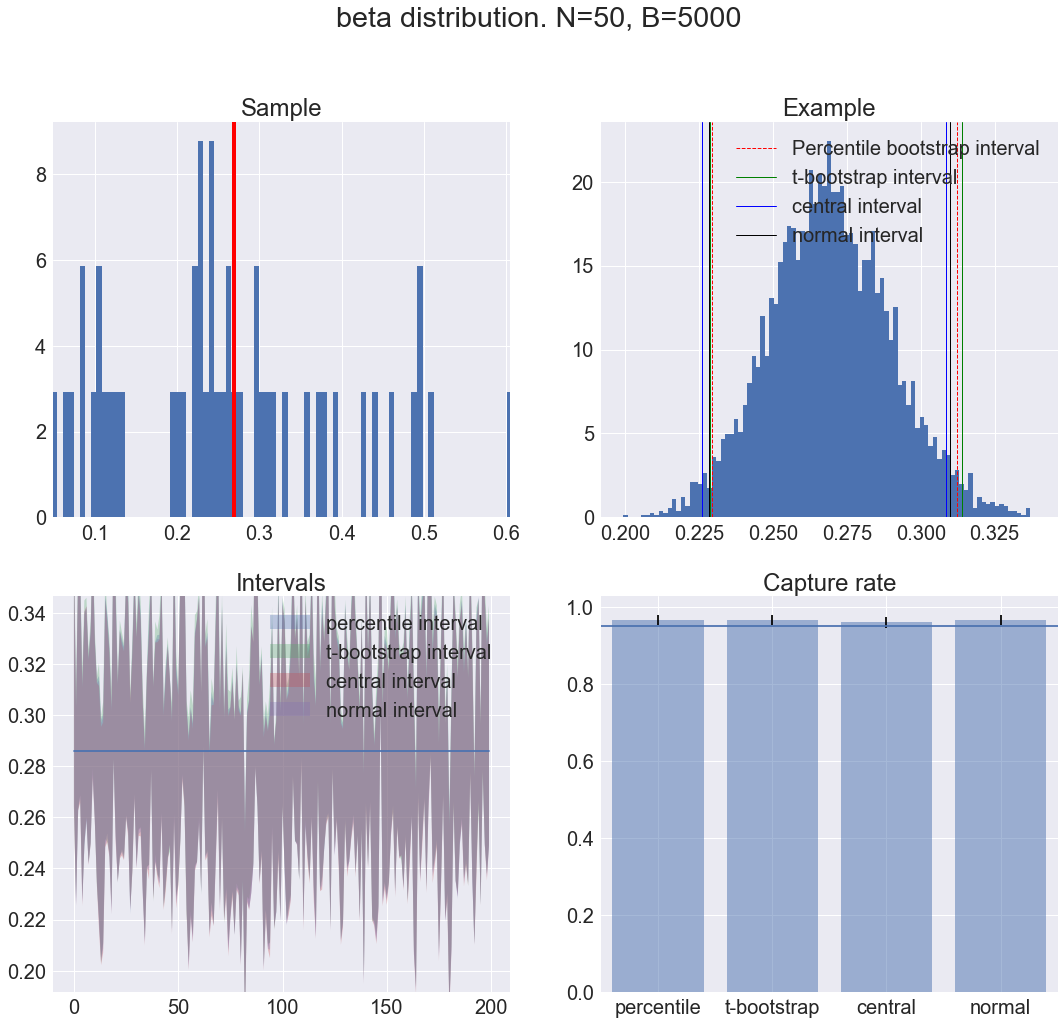

In [20]:
plot_statistics(beta(a=2, b=5), true_mean=2 / (2 + 5))

#### Выводы

Как видно, `t-bootstrap` показывает более хорошее качество в случае с не симметричными распределениями. Этого и стоило ожидать, так как, вообще говоря, он относится к методам второго порядка класса pivotal(пивотальных) бутстрапов.

![](bootstraps.jpg)

# 3. Проверка гипотез. 

## 3.1 Задачка на монетку

Построить критерий для проверки гипотезы $H_0: p \!= 1/2$ при альтернативной гипотезе $H_1 : p \neq  1/2$ по результатам восьми испытаний, подчиняющихся схеме Бернулли. Вероятность ошибки первого рода $\alpha $ положить равной 0.05.


### Ошибки

![](./stat_errors.png)

В статистике различаются два вида ошибок: 
  * ошибка первого рода -- когда мы отвергаем гипотезу, а она верна;
  * ошибка второго рода -- когда мы __не__ отвергаем гипотезу, а она не верна.
    (т.е. неверно приняли приняли нулевую гипотезу)
  
  
![](https://openlab-flowers.inria.fr/uploads/default/original/2X/7/703b9d4e3037b266e8fc6b20e020eb84d4405a80.png)


$$p\mathrm{-value} = 1 - \int\limits_{-\infty}^{t_{\alpha}} p_{H_0}(t) dt$$

Теперь мы фиксируем ошибку первого рода:

$$\alpha=0.05$$

Что означает следующее:

$$P(x < x' | H_0) = P(x > x'' | H_0) \leq \frac{\alpha}{2} = 0.025$$

In [21]:
alpha = 0.05

In [22]:
sns.set(font_scale=3)

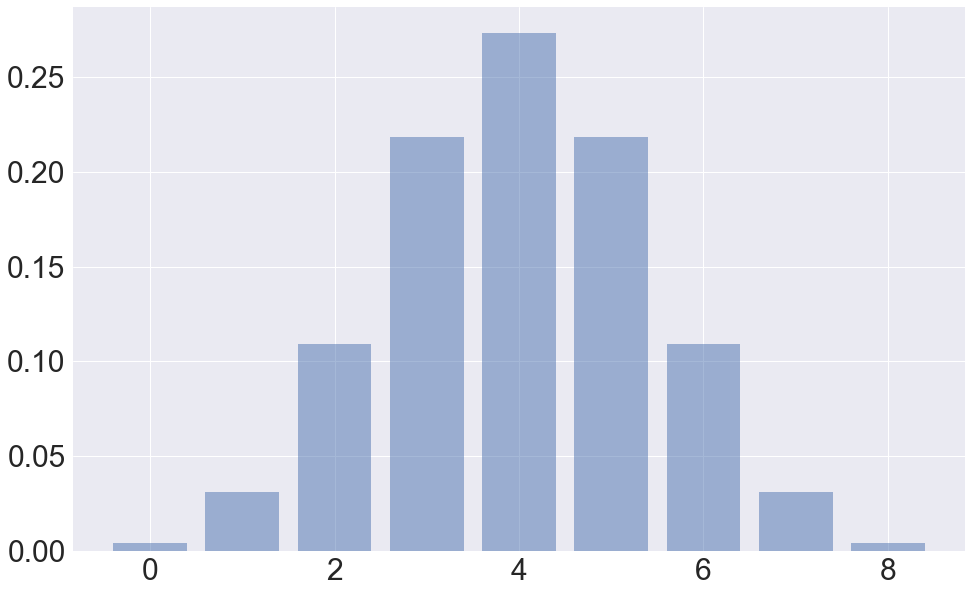

In [23]:
import scipy, scipy.stats
from scipy.stats import binom
import scipy, scipy.stats
x = np.arange(0, 9)
pmf = binom.pmf(x, 8, 0.5)

plt.figure(figsize=(16, 10))
plt.bar(x, pmf, alpha=0.5)
plt.show()

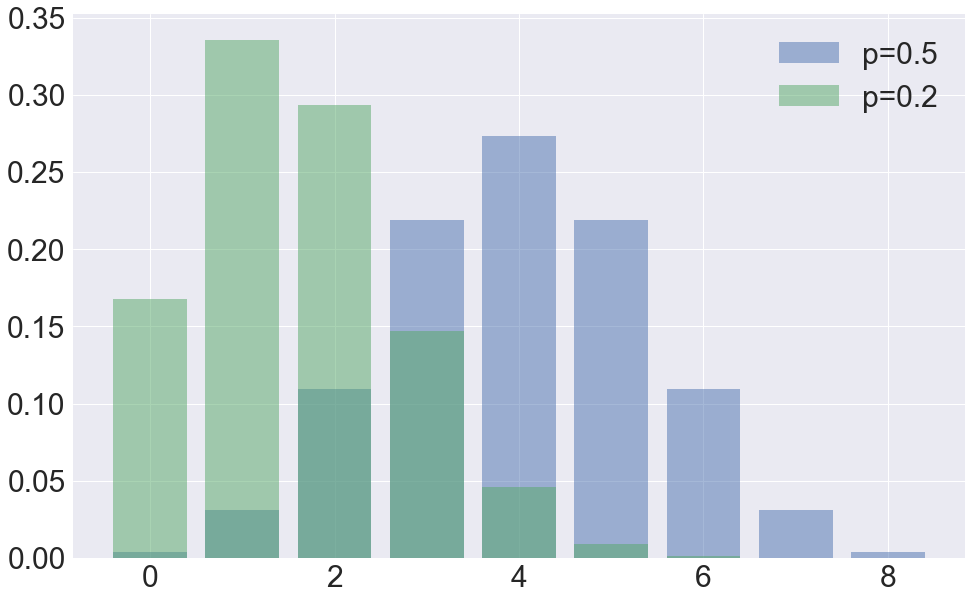

In [24]:
x = np.arange(0, 9)

plt.figure(figsize=(16, 10))

pmf = binom.pmf(x, 8, 0.5)
plt.bar(x, pmf, alpha=0.5, label='p=0.5')

pmf = binom.pmf(x, 8, 0.2)
plt.bar(x, pmf, alpha=0.5, label='p=0.2')

plt.legend()
plt.show()

In [25]:
distr = binom(n=8, p=0.5)

In [26]:
distr.pmf(0), distr.pmf(0) < alpha / 2

(0.003906250000000001, True)

In [27]:
distr.pmf(1), distr.pmf(1) < alpha / 2

(0.031250000000000014, False)

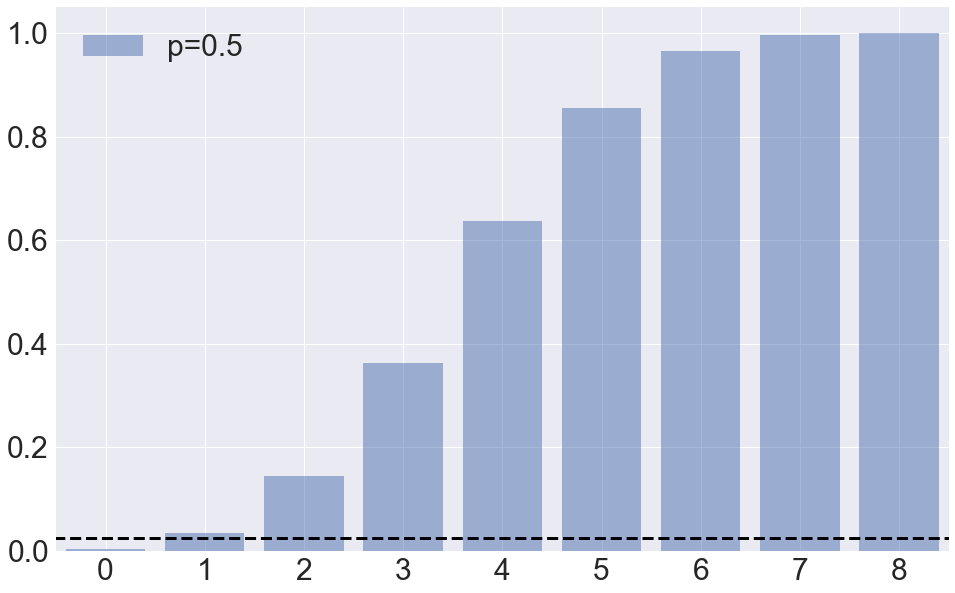

In [28]:
x = np.arange(-1, 10)

plt.figure(figsize=(16, 10))

pmf = binom.cdf(x, 8, 0.5)
plt.bar(x, pmf, alpha=0.5, label='p=0.5')

plt.plot(x, alpha * np.ones(len(x)) / 2, 'k', linewidth=3, linestyle='--')

plt.xlim(-0.5, 8.5)
plt.legend()
plt.show()

#### Получается что не получается построить гипотезу!

Мы применяем так называемое рандомизированное правило.

Т.е. мы говорим что гипотеза $H_0$ о $p = 0.5$ отвергается когда только одна монетка выпадает орлом. 

И отвергаем с вероятностью $w$, когда две монетки выпадают орлом.

Посчитаем эту вероятность $w$:

$$0.0039 + w \cdot 0.03125 = \frac{\alpha}{2}$$


$$w = 0.6752$$

Т.е. увидев только два орла(или две решки, так как задача симметричная) мы должны отклонить гипотезу о $p=0.5$ с вероятностью 0.6752.

In [29]:
def test_hypothesis(samples):
    rejected = (samples == np.random.choice([-1, 7], p=[1 - 0.6752, 0.6752], size=len(samples))).sum()
    rejected += (samples == np.random.choice([-1, 1], p=[1 - 0.6752, 0.6752], size=len(samples))).sum()
    rejected += (samples == 0).sum()
    rejected += (samples == 8).sum()
    return rejected / len(samples)

In [30]:
distr = binom(n=8, p=0.5)
samples = distr.rvs(size=10000)
print('Эмпирическая ошибка первого рода: {}'.format(test_hypothesis(samples=samples)))

Эмпирическая ошибка первого рода: 0.0505


In [31]:
ps = np.linspace(0, 1, 50)
betas = []
for p in ps:
    distr = binom(n=8, p=p)
    samples = distr.rvs(size=10000)
    betas.append(1 - test_hypothesis(samples=samples))

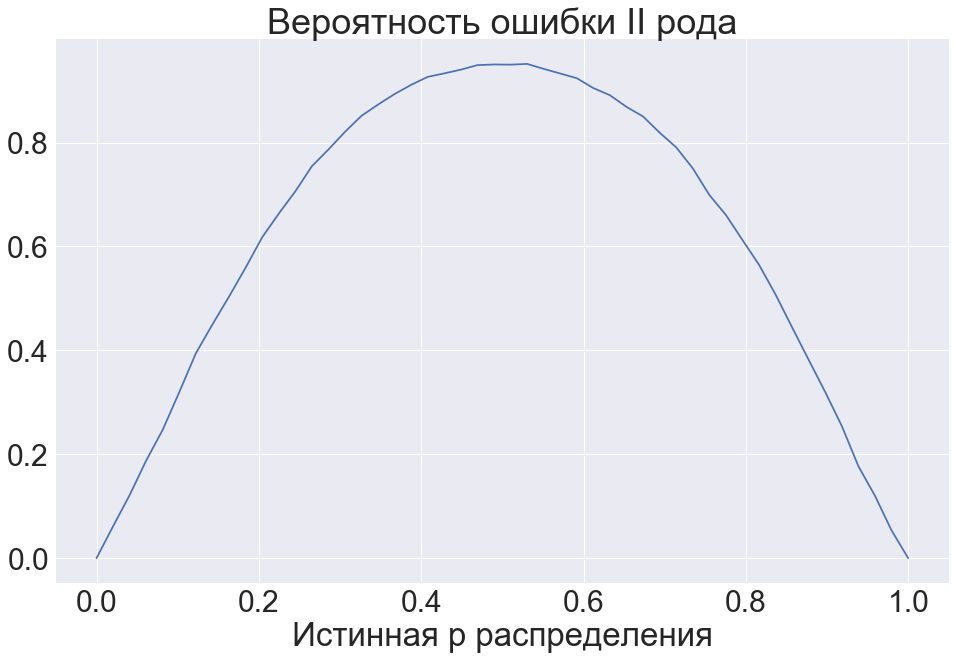

In [32]:
plt.figure(figsize=(16, 10))

plt.plot(ps, betas)
plt.title('Вероятность ошибки II рода')
plt.xlabel('Истинная p распределения')
plt.show()

## 3.2 Тест Уелча на примере рака груди

В данной задаче мы будем классифицировать злокачественные и доброкачественные опухоли груди. 

Мы запустим два классификатора и будем сравнивать качество прогноза и оценивать статистическую значимость разницы в качестве.

In [33]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")

In [34]:
df = pd.read_csv('data.csv');
df.drop(df.columns[[-1, 0]], axis=1, inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Первым делом - изучение датасета


 	 The data has 569 diagnosis, 357 malignant and 212 benign.


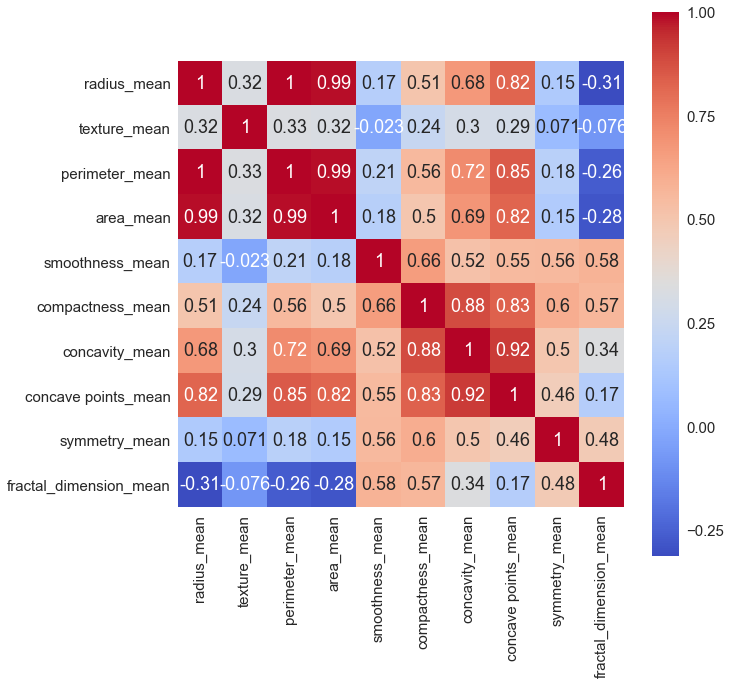

In [35]:
diagnosis_all = list(df.shape)[0]
diagnosis_categories = list(df['diagnosis'].value_counts())

print("\n \t The data has {} diagnosis, {} malignant and {} benign.".format(diagnosis_all, 
                                                                            diagnosis_categories[0], 
                                                                            diagnosis_categories[1]))
features_mean= list(df.columns[1:11])
plt.figure(figsize=(10,10))
sns.heatmap(df[features_mean].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

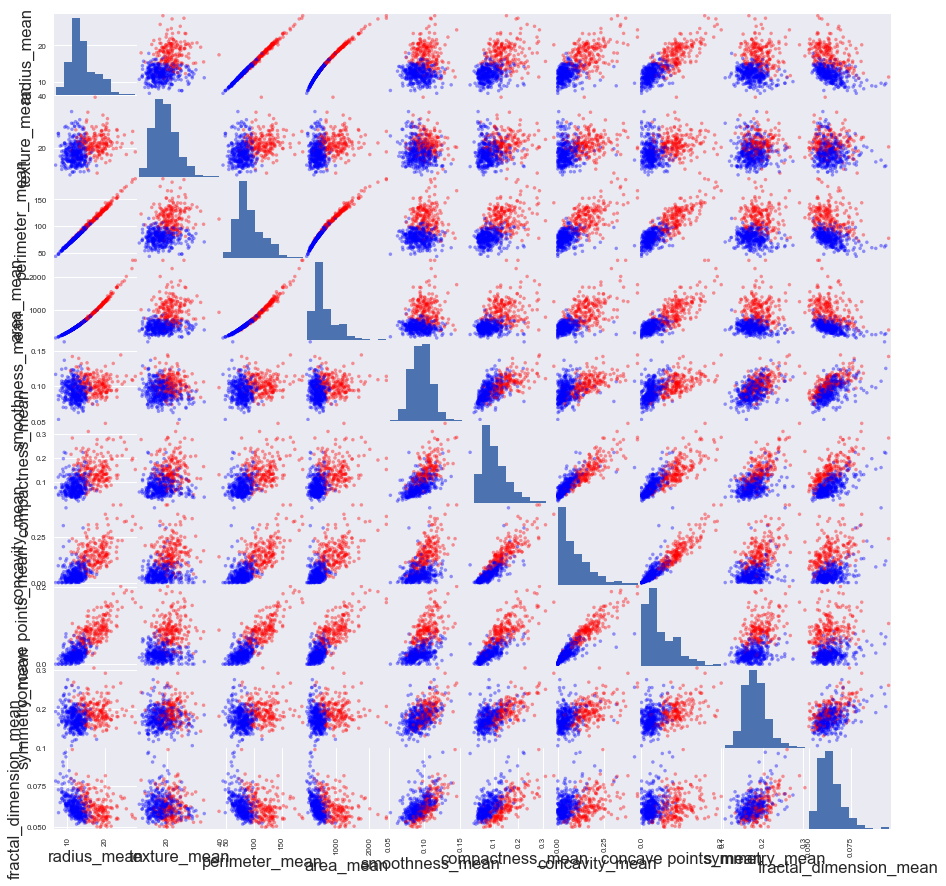

In [36]:
color_dic = {'M':'red', 'B':'blue'}
colors = df['diagnosis'].map(lambda x: color_dic.get(x))

sm = pd.scatter_matrix(df[features_mean], c=colors, alpha=0.4, figsize=((15,15)));

plt.show()

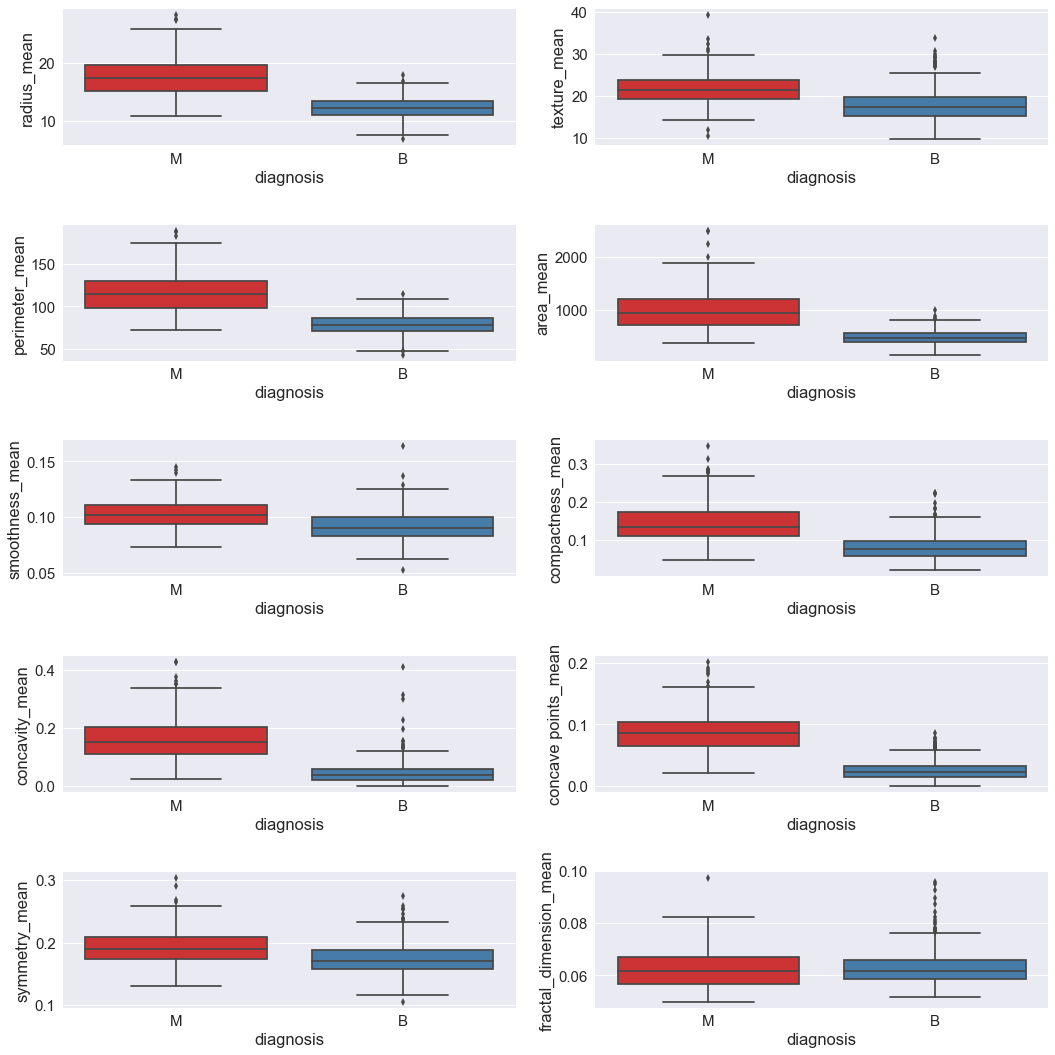

In [37]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(features_mean):
    rows = int(len(features_mean)/2)
    plt.subplot(rows, 2, i+1)
    sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set1")
plt.tight_layout()
plt.show()

### Тест Уельча

В отличии от $t-test$ в тесте Уельча ослабляется требование на одинаковую дисперсию двух сэмплов. Но остаётся требование нормального распределения статистик.

https://openlab-flowers.inria.fr/t/how-many-random-seeds-should-i-use-statistical-power-analysis-in-deep-reinforcement-learning-experiments/457

https://arxiv.org/pdf/1806.08295.pdf


![Тест Уелча](http://www.statistics4u.com/fundstat_eng/img/hl_explain_welch_test.png)

Импортируем функции для подсчёта бутстрапных статистик:

  * `def bootstrap` отвечает за подсчёт интервалов с помощью бутстрапа;
  * `bootstrap_ab` производит A/B-тестирование на двух сэмплах с помощью бутстрапа;
  * `bootstrap_test` - обёртка над `bootstrap_ab`, которая дополнительно сообщает прошли ли данные тест со значимостью на уровне $\alpha$.

In [38]:
from bootstrapped import *
from tests import bootstrap, bootstrap_ab, bootstrap_test
from tests import compute_beta, welch_test, empirical_false_pos_rate, plot_beta

In [39]:
# training the models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import time

diag_map = {'M':1, 'B':0}
df['diagnosis'] = df['diagnosis'].map(diag_map)

X = df.loc[:,features_mean]
y = df.loc[:, 'diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

accuracy_all = []
cvs_all = []

In [40]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores_knn = cross_val_score(clf, X, y, cv=100)

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores_knn))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores_knn), np.std(scores_knn)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 93.86%
Cross validation score: 89.02% (+/- 29.13%)
Execution time: 0.24416 seconds 



In [41]:
#The Naive Bayes algorithm applies Bayes’ theorem with the assumption of independence between every pair of features.
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

start = time.time()

clf = GaussianNB() #  SGDClassifier(random_state=42)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores_gnb = cross_val_score(clf, X, y, cv=100)
end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores_gnb))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores_gnb), np.std(scores_gnb)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))


Accuracy: 94.74%
Cross validation score: 91.36% (+/- 25.28%)
Execution time: 0.24639 seconds 



### Выставим ограничения на $\alpha$ и $\beta$: ошибки первого и второго рода

In [42]:
# ошибка первого рода
alpha = 0.05

# ошибка первого рода
beta_requirement = 0.2

# размер выборки
sample_size = range(2, 50, 2)

if scores_knn.mean() < scores_gnb.mean():
    m_smaller = scores_knn.mean()
else:
    m_smaller = scores_gnb.mean()

# effect size -- какую разницу мы хотим уметь детектить?
epsilon = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) * m_smaller
epsilon = epsilon.tolist()

In [43]:
welch_test(scores_knn, scores_gnb, alpha, tail=2)
bootstrap_test(scores_knn, scores_gnb, alpha)



Results of the Welch's t-test level 00.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Welch's t-test done.


Results of the bootstrap test level 00.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Bootstrap test done.




Computing empirical false positive rate ..
     N = 2
     N = 4
     N = 6
     N = 8
     N = 10
     N = 12
     N = 14
     N = 16
     N = 18
     N = 20
     N = 22
     N = 24
     N = 26
     N = 28
     N = 30
     N = 32
     N = 34
     N = 36
     N = 38
     N = 40
     N = 42
     N = 44
     N = 46
     N = 48

   Given N=50 and α=00.05, you can expect false positive rates: 
     For the Welch's t-test: 0.038 
     For the bootstrap test: 0.041.
Done.


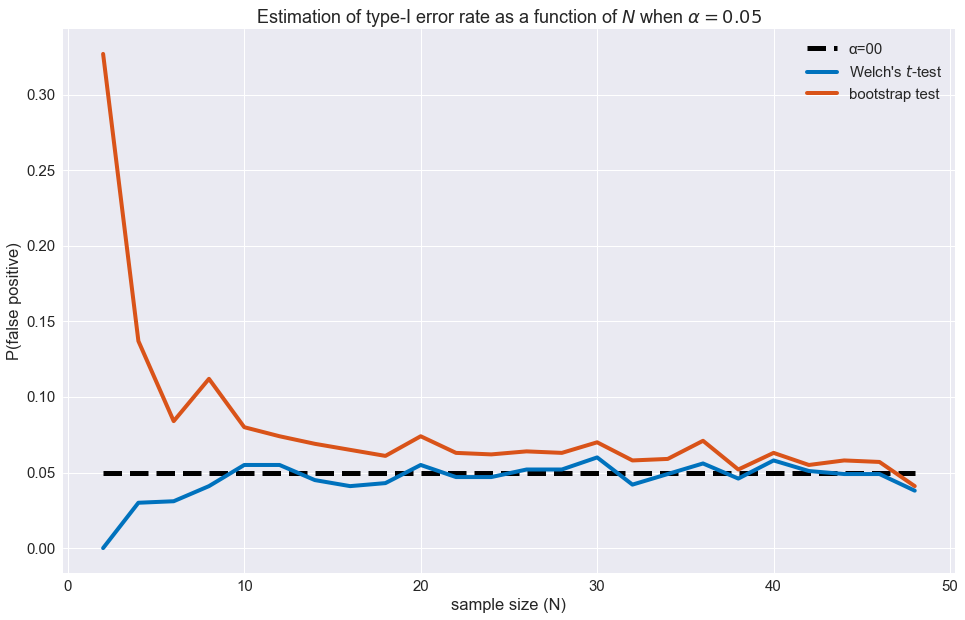

In [44]:
# выборка случайно бьётся на равные части 
# и для них случайно делается разбиение 
# и смотрится на ошибку первого рода
empirical_false_pos_rate(scores_knn, alpha)



Computing the false negative rate as a function of sample size, for various effect sizes ..

Sample sizes satisfying β=0.2 are:
     ε = 0.08901904761904764  -->  N: 32 
     ε = 0.17803809523809527  -->  N: 10 
     ε = 0.2670571428571429  -->  N: 6 
     ε = 0.35607619047619055  -->  N: 4 
     ε = 0.44509523809523815  -->  N: 4 
     ε = 0.5341142857142858  -->  N: 4 
     ε = 0.6231333333333334  -->  N: 2 
     ε = 0.7121523809523811  -->  N: 2 
     ε = 0.8011714285714286  -->  N: 2 
     ε = 0.8901904761904763  -->  N: 2 
 
Done.
[0.08901904761904764, 0.17803809523809527, 0.2670571428571429, 0.35607619047619055, 0.44509523809523815, 0.5341142857142858, 0.6231333333333334, 0.7121523809523811, 0.8011714285714286, 0.8901904761904763]


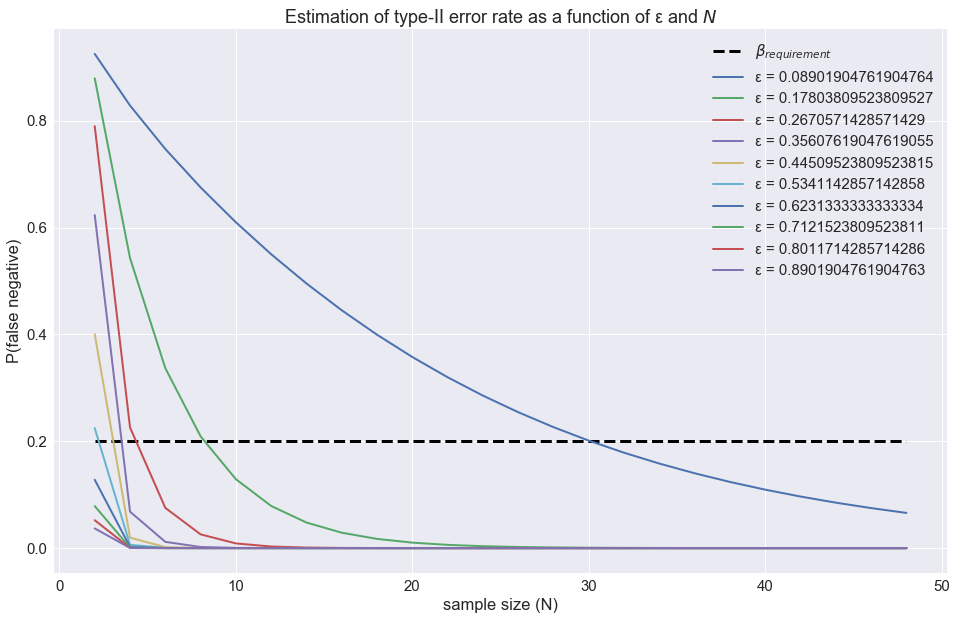

In [45]:
# чисто аналитический анализ
# выборки используются только чтобы посчитать std
beta = compute_beta(epsilon, sample_size, alpha, scores_knn, scores_gnb, beta_requirement=beta_requirement)

plot_beta(beta, epsilon, sample_size, beta_requirement=beta_requirement)
plt.show()

## 3.3 Критерий Манна-Уитни

| Версия сайта | Общее количество визитов | Конверсия | Конверсия в процентах |
|--------------|--------------------------|-----------|-----------------------|
|  Version 1   | 10283                    | 3714      | 36%                   |
|  Version 2   | 2742                     | 1587      | 58%                   |
| Version 3    | 2747                     | 1652      | 60%                   |
| Version 4    | 3180                     | 1717      | 54%                   |
| Version 5    | 2064                     | 1348      | 65%                   |

Какой же вариант сайта лучше, а какие статистически объяснимые девиации от их своеобразных средних уровней?

##### Критерий Манна-Уитни(крестьянско-рабочий алгоритм)

Критерий Манна-Уитни используется для сравнения средних двух групп.

Cтатистика U считается следующим образом для двух выборок X и Y: 
  0. $U_1 = 0$
  1. Берутся все пары из двух выборок: $(x_i, y_i)$;
  2. Если $x_i > y_i$, то $U_1 += 1$;
  3. Если $x_i == y_i$, то $U_1 += 0.5$;
  4. Аналогично считается $U_2$ по парам $(y_i, x_i)$;
  5. $U = min(U_1, U_2)$
 
При больших размерах выборки:

$$U \sim N\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

При большой выборке и возможных ничьих $\sigma$ считается по-другому:

$$
\sigma = \sqrt{ \frac{nm}{(m + n) (m + n - 1)} \cdot \left[ \frac{(m + n)^3 - (m + n)}{12} - \sum \frac{t_j^3 - t_j}{12} \right]},
$$

где $t_j$ -- количество ничьих.


#### Замечательность рангового теста Манна-Уитни: 

  * работает для всех типов данных данных: дискретные, не нормально распределённые;
  * не обращает внимание на outliers;
  * связан с ROC-AUC.
  
  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1120984/

In [46]:
data = np.array([
    [10283, 3714],
    [2742, 1587],
    [2747, 1652],
    [3180, 1717],
    [2064, 1348]
])

alpha = 0.05 / 5 # 5 потому что бонферотти

In [47]:
def mann_whitney(conversion_1, conversion_2, alpha=0.05):
    """
    conversion = (N, n), где N -- общее число визитов, n -- конверсия
    True => H_0 отклоняется => средние не равны
    """
    U_1 = conversion_1[1] * (conversion_2[0] - conversion_2[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    U_2 = conversion_2[1] * (conversion_1[0] - conversion_1[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    
    mean = conversion_1[0] * conversion_2[0] / 2
    N = conversion_1[0] + conversion_2[0]
    mn = conversion_1[0] * conversion_2[0]
    t_1 = (conversion_1[0] - conversion_1[1]) + (conversion_2[0] - conversion_2[1])
    t_2 = conversion_1[1] + conversion_2[1]
    std = (mn / (N * (N - 1))) * ((N**3 - N) / 12 - 
                                 (t_1**3 - t_1) / 12 - 
                                 (t_2**3 - t_2) / 12 )
    std = np.sqrt(std)
    z = np.abs(min(U_1, U_2) - mean) / std 
    return z, z > norm.ppf(1 - alpha / 2)

## Тест Вальда

Статистика на которую мы смотрим:

$$T = \frac{\hat{p}_1 - \hat{p}_2}{\hat{se}}$$

Где дисперсия считается следующим образом:

$$\hat{se}^2 = \hat{se}_1^2 + \hat{se}_2^2$$

$$\hat{se}_1^2 = \frac{p_1 (1 - p_1)}{n_1}$$

Тестовая статистика имеет следующее распределение:

$$T \sim \mathcal{N}(0, 1)$$

In [48]:
from scipy.stats import norm
def wald_test(conversion_1, conversion_2, alpha=0.05):
    """
    Проверяется Вальд для Бернулли. 
    True => H_0 отклоняется => средние не равны.
    """
    p_1 = conversion_1[1] / conversion_1[0]
    p_2 = conversion_2[1] / conversion_2[0]
    se_1 = np.sqrt(p_1 * (1 - p_1) / conversion_1[0])
    se_2 = np.sqrt(p_2 * (1 - p_2) / conversion_2[0])
    se = np.sqrt(se_1**2 + se_2**2)
    return np.abs((p_1 - p_2) / se), np.abs((p_1 - p_2) / se) > norm.ppf(1 - alpha / 2)

In [49]:
from collections import defaultdict
results_mww = defaultdict(lambda: defaultdict(bool))
z_mww = []
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = mann_whitney(data[i], data[j], alpha=alpha)
        print(z)
        z_mww.append(z)
        results_mww[i][j] = flag
        if results_mww[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                                         data[i][1] / data[i][0], 
                                                                                                         j+1,
                                                                                                         data[j][1] / data[j][0]))
        print()

0.0
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

20.607089406964572
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

22.72339288118447
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

17.95738651374319
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

24.60758946032845
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

20.607089406964572
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

1.7027432222795187
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

3.000484275270596
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 4 с конверсией 0.54

5.230413282646482
Версия сайта 2 с конверсией 0.58 ст

In [50]:
from collections import defaultdict
results_wald = defaultdict(lambda: defaultdict(bool))
z_wald = []
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = wald_test(data[i], data[j], alpha=alpha)
        print(z)
        z_wald.append(z)
        results_wald[i][j] = flag
        if results_wald[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                 data[i][1] / data[i][0],
                                                                                 j+1,
                                                                                 data[j][1] / data[j][0]))
        print()

0.0
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

20.620895355293204
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

22.93344269021802
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

17.826653746799323
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

25.388815771018628
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

20.620895355293204
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

1.70333528052776
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

3.0051027852151844
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 4 с конверсией 0.54

5.273099827112846
Версия сайта 2 с конверсией 0.58 с

# 4. Коррекция на множественные тесты при построении GLM

Будем считать пермутационную регессию с МНК (Ordinary Least Squares) для каждого вокселя, чтобы найти области мозга (группы воскелей), которые активируется по-разному algorithm is run at each voxel in order to detemine whether or not it behaves differently under a “face viewing” condition and a “house viewing” condition. We consider the mean image per session and per condition. Otherwise, the observations cannot be exchanged at random because a time dependance exists between observations within a same session (see [1] for more detailed explanations).

The example shows the small differences that exist between Bonferroni-corrected p-values and family-wise corrected p-values obtained from a permutation test combined with a max-type procedure [2]. Bonferroni correction is a bit conservative, as revealed by the presence of a few false negative

Пример из `nilern`: https://nilearn.github.io/decoding/decoding_intro.html

[1] Winkler, A. M. et al. (2014).
Permutation inference for the general linear model. Neuroimage.

[2] Anderson, M. J. & Robinson, J. (2001).
Permutation tests for linear models. Australian & New Zealand Journal of Statistics, 43(1), 75-88. (http://avesbiodiv.mncn.csic.es/estadistica/permut2.pdf)

##### Работаем с данными из датасета Haxby

Haxby et al. (2001): Faces and Objects in Ventral Temporal Cortex (fMRI) - височная кора головного мозга 
https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_stimuli.html

![Датасет](https://www.researchgate.net/profile/Martin_Hebart/publication/270749420/figure/fig2/AS:272567755866138@1441996625521/Results-of-analyses-on-Haxby-2001-data-set-A-Confusion-matrix-reflecting-the-confusion.png)

Brain mapping

https://youtu.be/k61nJkx5aDQ?t=15

In [51]:
import nilearn
import pandas as pd
from nilearn import datasets
from scipy.misc import imread
from nilearn import datasets
from nilearn.plotting import show

In [52]:
#Load Haxby dataset
haxby_dataset = datasets.fetch_haxby(subjects=[2], fetch_stimuli=True)
haxby_dataset.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [53]:
stimulus_information = haxby_dataset.stimuli

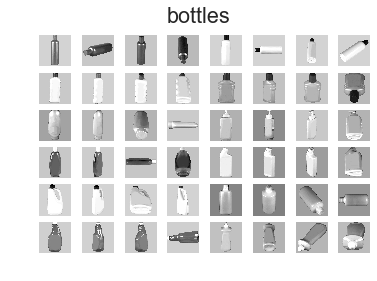

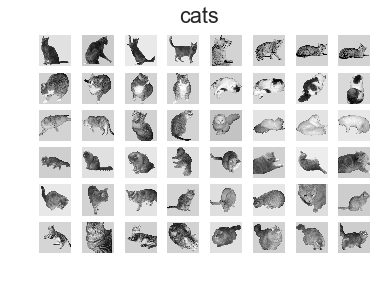

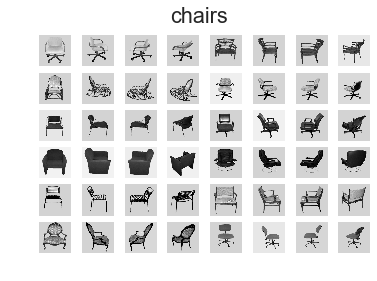

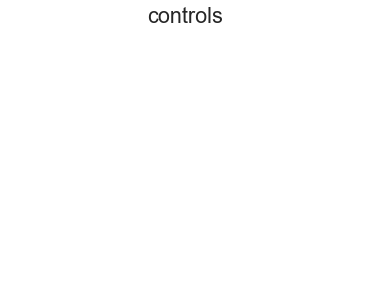

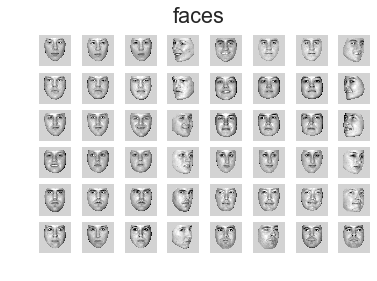

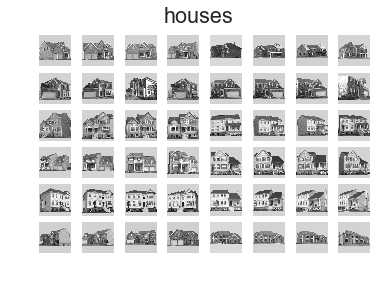

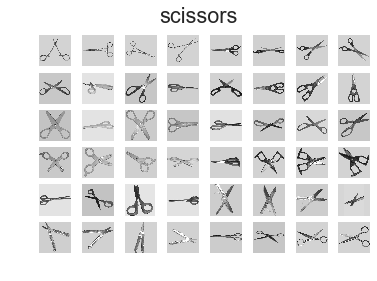

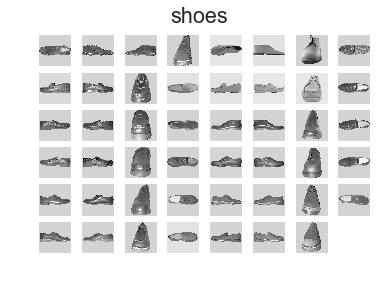

In [54]:
for stim_type in sorted(stimulus_information.keys()):
    if stim_type == b'controls':
        continue
    file_names = stimulus_information[stim_type]
    plt.figure()
    for i in range(48):
        plt.subplot(6, 8, i + 1)
        try:
            plt.imshow(imread(file_names[i]), cmap=plt.cm.gray)
        except:
            pass
        plt.axis("off")
    plt.suptitle(stim_type)
show()

In [55]:
print(haxby_dataset.func[0])
img_temp = nilearn.image.load_img(haxby_dataset.func[0])
print(img_temp.shape)

/home/acappello/nilearn_data/haxby2001/subj2/bold.nii.gz
(40, 64, 64, 1452)


In [56]:
print(haxby_dataset.session_target[0])
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']
print(behavioral.shape)
behavioral.head()

/home/acappello/nilearn_data/haxby2001/subj2/labels.txt
(1452, 2)


,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


In [57]:
# Размер одного фмрт изображения, где первые 3 начения это разрешения 3D картинки и 1452 отсчета по времени
print(img_temp.shape)
# И для каждого отсчета известны ключи (визуальные стимулы) для task-based fMRI 
print(conditions.shape)

(40, 64, 64, 1452)
(1452,)


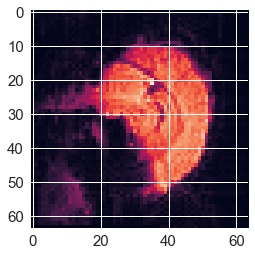

In [58]:
# Воксель - это 3D пиксель. 
# То есть ниже [20,...] -- двухмерный срез пикселей из трехмерного массива, 800 -- отсчет времени
plt.imshow(img_temp.dataobj[20, ..., 800])
# Тут же можно оценить глазами интенсивность каждого вокселя: условно, 
# чем больше крови аккумулируется в данном участке мозга,
# тем интенсивнее сигнал и тем выше активность этого этого региона для каждой когнитивной функции.

![Зачем мы маскируем](http://nilearn.github.io/_images/masking.jpg)

Выберем только нужные вокселы для анализа (домножим 4D массивы на маску): 
Мы работаем уже с предобработанными мозгами в специальном софте: для нас мозги повернули, проскалировали, алайнили друг с другом и натянули на "шаблонный мозг" в специальной координатной системе MNI.

![Mask for fMRI series](https://nilearn.github.io/_images/sphx_glr_plot_visualization_0021.png)

In [59]:
# mask data
mask_filename = haxby_dataset.mask
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8, mask_img=mask_filename, memory='nilearn_cache', memory_level=1)  # cache options
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)

In [60]:
# Теперь у нас есть 2D массив, который мы и будем использовать в качестве датасета.
# Каждому визуальному ключу ( отсчету времени) соотносятся интенсивности вокселей
# (да, да все воксели кортикальной височной зоны для 1 человека из 6):
print(fmri_masked.shape)
# То есть 
print('Для целикового изображения было бы {}, но мы снизили размерность в 4 раза, наложив маску до 39912'.format(40*64*64))

(1452, 39912)
Для целикового изображения было бы 163840, но мы снизили размерность в 4 раза, наложив маску до 39912


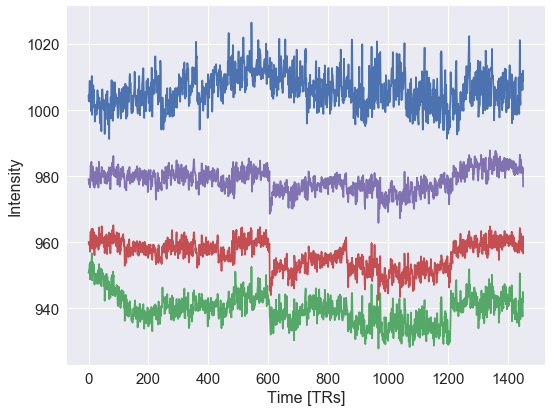

In [61]:
# Посмотрим на то, как изменяется сигнал интенсивности одного вокселя во времени (для 1 человека)
plt.figure(figsize=(8, 6))
plt.plot(fmri_masked[:, 11132:11136])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
show()

#### Ограничем наши данные домами и лицами

In [62]:
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

conditions = labels['labels']
categories = conditions.unique()
conditions_encoded = np.zeros_like(conditions)

for c, category in enumerate(categories):
    conditions_encoded[conditions == category] = c

sessions = labels['chunks']
condition_mask = conditions.isin(['face', 'house'])
conditions_encoded = conditions_encoded[condition_mask]
fmri_masked = fmri_masked[condition_mask]

# Мы посчитаем, среднее изображение и состояние сессии.
# В противном случае, наблюдения не могут быть обменены в случайном порядке, потому что
# существует зависимость между наблюдениями в рамках одной сессии.
n_sessions = np.unique(sessions).size
grouped_fmri_masked = np.empty((2 * n_sessions,  # two conditions per session
                                fmri_masked.shape[1]))
grouped_conditions_encoded = np.empty((2 * n_sessions, 1))

for s in range(n_sessions):
    session_mask = sessions[condition_mask] == s
    session_house_mask = np.logical_and(session_mask,
                                        conditions[condition_mask] == 'house')
    session_face_mask = np.logical_and(session_mask,
                                       conditions[condition_mask] == 'face')
    grouped_fmri_masked[2 * s] = fmri_masked[session_house_mask].mean(0)
    grouped_fmri_masked[2 * s + 1] = fmri_masked[session_face_mask].mean(0)
    grouped_conditions_encoded[2 * s] = conditions_encoded[
        session_house_mask][0]
    grouped_conditions_encoded[2 * s + 1] = conditions_encoded[
        session_face_mask][0]

In [63]:
# То есть выбрали только для 2х тем ( по 12 сессия каждая) и размерность осталась как у каждого человека
grouped_fmri_masked.shape

(24, 39912)

In [64]:
# Посмотрим на наши ключи:
# визуальные стимулы показывали сессиями chunks по 9 временных отсчетов (временной интервал около 2.5 секунд). 
# можно, кстати, посчитать, что люди лежали в томографе 2.5*1452/3600=1.008 - почти час
# всего сессий было 12.
labels['labels'].value_counts()

rest            588
chair           108
scrambledpix    108
house           108
face            108
bottle          108
cat             108
shoe            108
scissors        108
Name: labels, dtype: int64

In [65]:
grouped_conditions_encoded.shape

(24, 1)

In [66]:
grouped_fmri_masked.shape

(24, 39912)

Оценим величину корреляции OLS (проверим гипотезу о линейной зависимости/независимости двух сессий  `Дома` и `Лица`).

Посчитаем соответсвующие p-values через two-sided t-test, и тут мы можем посмотреть на знак корреляции.

In [67]:
from nilearn.mass_univariate import permuted_ols
permuted_ols?

In [68]:
neg_log_pvals, t_scores_original_data, _ = permuted_ols(tested_vars=grouped_conditions_encoded, 
                                                        target_vars=grouped_fmri_masked,
                                                        n_perm=10000, two_sided_test=True,
                                                        n_jobs=-1)

signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)

signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(signed_neg_log_pvals)

In [69]:
from sklearn.feature_selection import f_regression
f_regression?

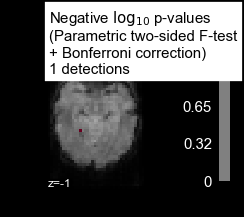

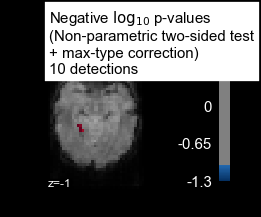

In [70]:
_, pvals_bonferroni = f_regression(X=grouped_fmri_masked, y=grouped_conditions_encoded)
# Давайте попробуем убрать эту коррекцию на множественное сравнение
pvals_bonferroni *= fmri_masked.shape[1] # Корреция на множественное сравнение (FDR) - Bonferroni to death
pvals_bonferroni[np.isnan(pvals_bonferroni)] = 1
pvals_bonferroni[pvals_bonferroni > 1] = 1
neg_log_pvals_bonferroni = -np.log10(pvals_bonferroni)
neg_log_pvals_bonferroni_unmasked = nifti_masker.inverse_transform(neg_log_pvals_bonferroni)

from nilearn.plotting import plot_stat_map, show

# Сконкатим все мозги, чтобы построить воксели на "усредненном" изображении
from nilearn import image
mean_fmri_img = image.mean_img(func_filename)

threshold = -np.log10(0.1)  # Попробуем тут эмпирический трешхолд 10% corrected

vmax = min(signed_neg_log_pvals.max(),
           neg_log_pvals_bonferroni.max())

# Plot thresholded p-values map corresponding to F-scores
display = plot_stat_map(neg_log_pvals_bonferroni_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

neg_log_pvals_bonferroni_data = neg_log_pvals_bonferroni_unmasked.get_data()
n_detections = (neg_log_pvals_bonferroni_data > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Parametric two-sided F-test'
         '\n+ Bonferroni correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

#  Карта с регрессионного анализа и соответсвующие p-values с МНК (OLS) анализа
display = plot_stat_map(signed_neg_log_pvals_unmasked, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[-1, ],
                        vmax=vmax)

n_detections = (np.abs(signed_neg_log_pvals) > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric two-sided test'
         '\n+ max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.1)

show()
    


In [71]:
bonferroni_mask = nilearn.image.new_img_like(neg_log_pvals_bonferroni_unmasked, neg_log_pvals_bonferroni_unmasked.get_data() > threshold)

In [72]:
ols_mask = nilearn.image.new_img_like(signed_neg_log_pvals_unmasked, signed_neg_log_pvals_unmasked.get_data() > threshold)

### Усилимся и подключим машинку, допустим метод опоных векторов (SVM)

Будем увеличивать точность классификации и попробуем классфицировать все объекты.


In [73]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from collections import defaultdict
from tqdm import tqdm

In [74]:
stimuli = labels['labels']
# Уберем сессии resting state -без визуального стимула
task_mask = (stimuli != 'rest')
# Создадим список названий стимулов
categories = stimuli[task_mask].unique()
# И сохраним лейблы для каждой из 12 сессий 
session_labels = labels["chunks"][task_mask]

In [75]:
# Будем классификацировать сессии методом опорных векторов
svc = SVC(C=1., kernel="linear")
lr = LogisticRegression()

In [76]:
from nilearn import image
func_filename = haxby_dataset.func[0]
mean_img = image.mean_img(func_filename)

In [77]:
# Будем классифицировать по отдельным людям и по 12 сессиям отдельно.
cv = 10

masks = {'bonferroni_mask': bonferroni_mask, 
         'ols_mask': ols_mask}

svc_scores = defaultdict(lambda: defaultdict(float))
lr_scores = defaultdict(lambda: defaultdict(float))
dummy_scores = defaultdict(lambda: defaultdict(float))

for mask_name, mask in tqdm(masks.items()):
    print("Working on mask %s" % mask_name)
    masker = NiftiMasker(mask_img=mask, standardize=True)
    masked_timecourses = masker.fit_transform(func_filename)[task_mask]
    classification_target = (stimuli[task_mask] == category)
    print(masked_timecourses.shape, classification_target.shape)

    for category in tqdm(categories):
        print("Processing %s %s" % (mask_name, category))
        classification_target = (stimuli[task_mask] == category)
        svc_scores[mask_name][category] = cross_val_score(estimator=svc, X=masked_timecourses,
                                                          y=classification_target, cv=cv, 
                                                          groups=session_labels, scoring="roc_auc")

        lr_scores[mask_name][category] = cross_val_score(estimator=lr, X=masked_timecourses,
                                                         y=classification_target, cv=cv, 
                                                         groups=session_labels, scoring="roc_auc")

  0%|          | 0/2 [00:00<?, ?it/s]

Working on mask bonferroni_mask



 25%|██▌       | 2/8 [00:00<00:00, 16.32it/s]

(864, 1) (864,)
Processing bonferroni_mask scissors
Processing bonferroni_mask face
Processing bonferroni_mask cat
Processing bonferroni_mask shoe



 75%|███████▌  | 6/8 [00:00<00:00, 15.72it/s]

Processing bonferroni_mask house
Processing bonferroni_mask scrambledpix
Processing bonferroni_mask bottle
Processing bonferroni_mask chair



 50%|█████     | 1/2 [00:12<00:12, 12.53s/it]

Working on mask ols_mask



 12%|█▎        | 1/8 [00:00<00:00,  9.96it/s]

(864, 10) (864,)
Processing ols_mask scissors
Processing ols_mask face



 38%|███▊      | 3/8 [00:00<00:00,  9.65it/s]

Processing ols_mask cat
Processing ols_mask shoe



 62%|██████▎   | 5/8 [00:00<00:00,  9.49it/s]

Processing ols_mask house
Processing ols_mask scrambledpix



100%|██████████| 2/2 [00:25<00:00, 12.67s/it]

Processing ols_mask bottle
Processing ols_mask chair


bonferroni_mask [0.5456435406698564, 0.5189486443381182, 0.4589328548644338, 0.5950771929824562, 0.4204307814992026, 0.5625387559808612, 0.5684886762360446, 0.5064751196172249]
ols_mask [0.6902350877192982, 0.5705189792663476, 0.5151460925039872, 0.598777990430622, 0.9571923444976077, 0.5329703349282298, 0.5407043062200957, 0.5382427432216905]


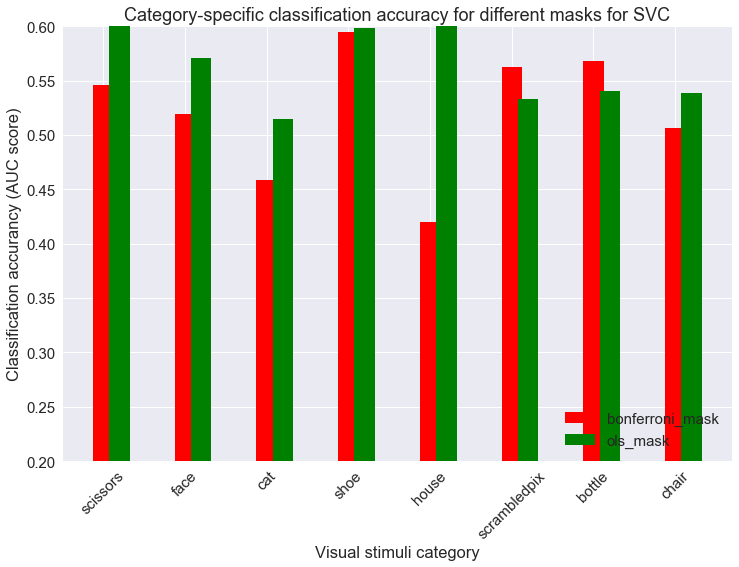

In [78]:
plt.figure(figsize=(12, 8))

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('rgb', masks.keys()):
    score_means = [svc_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)
    print(mask_name, score_means)
    tick_position = tick_position + .2

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.2, 0.6)
plt.legend(loc='lower right')
plt.title('Category-specific classification accuracy for different masks for SVC')

plt.show()

# Second-level fMRI model: a two-sample test

https://nistats.github.io/auto_examples/03_second_level_models/plot_second_level_two_sample_test.html

In [79]:
from nilearn import datasets
n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(n_subjects=n_samples)

In [80]:
cmap_filenames = localizer_dataset.cmaps

In [81]:
import pandas as pd
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])

In [82]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel().fit(
    cmap_filenames, design_matrix=design_matrix)

ModuleNotFoundError: No module named 'nistats'

In [ ]:
z_map = second_level_model.compute_contrast(output_type='z_score')

In [ ]:
from nistats.thresholding import map_threshold
thresholded_map1, threshold1 = map_threshold(
    z_map, level=.001, height_control='fpr', cluster_threshold=10)

In [ ]:
thresholded_map2, threshold2 = map_threshold(
    z_map, level=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

In [ ]:
thresholded_map3, threshold3 = map_threshold(
    z_map, level=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)

In [ ]:
from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map')

In [ ]:
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='Thresholded z map, fpr <.001, clusters > 10 voxels')

In [ ]:
plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)

In [ ]:
plotting.plot_stat_map(thresholded_map3, cut_coords=display.cut_coords,
                       title='Thresholded z map, expected fwer < .05',
                       threshold=threshold3)